In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.2.242:42493")
client

Client Scheduler: tcp://10.32.2.242:42493 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 30 Cores: 60 Memory: 345.00 GB


# Cumulative volume time derivative ($\frac{\partial \mathcal{V}}{\partial t}$)

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_th.zarr'))
ds_tmp

<xarray.Dataset>
Dimensions:                  (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * XC                       (XC) float32 0.083333336 0.25 ... 359.75 359.9167
  * YC                       (YC) float32 -77.87497 -77.7083 ... -24.7083
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>

In [4]:
ds_tmp_surf_terms = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_surf_th.zarr'))
ds_tmp_surf_terms

<xarray.Dataset>
Dimensions:               (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * XC                    (XC) float32 0.083333336 0.25 ... 359.75 359.9167
  * YC                    (YC) float32 -77.87497 -77.7083 ... -24.7083
  * Z                     (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                  (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    lin_fs_correction_TH  (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    surface_flux_conv_TH  (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    sw_flux_conv_TH       (time, YC, XC, Z) float32 dask.array<chunksize=(1, 320, 2160, 41), meta=np.ndarray>

In [5]:
ds_t_s = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/t_s.zarr'))
ds_t_s

<xarray.Dataset>
Dimensions:  (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, time: 438)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG       (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    SALT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    THETA    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>

In [6]:
vels = ds_t_s.UVEL.to_dataset()
vels['VVEL'] = ds_t_s.VVEL
vels['WVEL'] = ds_t_s.WVEL

ds_t_s = ds_t_s.drop_vars(['UVEL', 'VVEL', 'WVEL'])

In [7]:
dsr_tmp = xr.merge([ds_tmp, ds_tmp_surf_terms, ds_t_s])
dsr_tmp

<xarray.Dataset>
Dimensions:                  (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, time: 438)
Coordinates:
  * XC                       (XC) float32 0.083333336 0.25 ... 359.75 359.9167
  * YC                       (YC) float32 -77.87497 -77.7083 ... -24.7083
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * XG                       (XG) float32 5.551115e-17 0.16666667 ... 359.83334
  * YG                       (YG) float32 -77.9583 -77.79163 ... -24.791632
  * Zl                       (Zl) float32 0.0 -10.0 -21.0 ... -5200.0 -5450.0
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    lin_fs_correction_TH     (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    surface_flux_conv_TH     (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    sw_flux_conv_TH          (time, YC, XC, Z) float32 dask.array<chunksize=(1, 320, 2160, 41), meta=np.ndarray>
    SALT                     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    THETA                    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>

In [8]:
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/coords.zarr'))
coords

<xarray.Dataset>
Dimensions:  (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG       (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1      (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu       (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    Depth    (YC, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    PHrefC   (Z) float32 dask.array<chunksize=(42,), meta=np.ndarray>
    PHrefF   (Zp1) float32 dask.array<chunksize=(43,), meta=np.ndarray>
    drC      (Zp1) float32 dask.array<chunksize=(43,), meta=np.ndarray>
    drF      (Z) float32 dask.array<chunksize=(42,), meta=np.ndarray>
    dxC      (YC, XG) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    dxG      (YG, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    dyC      (YG, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    dyG      (YC, XG) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    hFacC    (Z, YC, XC) float32 dask.array<chunksize=(42, 320, 2160), meta=np.ndarray>
    hFacS    (Z, YG, XC) float32 dask.array<chunksize=(42, 320, 2160), meta=np.ndarray>
    hFacW    (Z, YC, XG) float32 dask.array<chunksize=(42, 320, 2160), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(438,), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    rAs      (YG, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    rAw      (YC, XG) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    rAz      (YG, XG) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>

### WG Boundaries

In [9]:
lower_lat = 0
upper_lat = 78
left_lon = 1788
right_lon = 2159

In [10]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [11]:
ds_tmp_wg = dsr_tmp.isel(**lat_range, **lon_range)
ds_tmp_wg

<xarray.Dataset>
Dimensions:                  (XC: 371, XG: 2160, YC: 78, YG: 320, Z: 42, Zl: 42, time: 438)
Coordinates:
  * XC                       (XC) float32 298.08334 298.25 ... 359.58334 359.75
  * YC                       (YC) float32 -77.87497 -77.7083 ... -65.04163
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * XG                       (XG) float32 5.551115e-17 0.16666667 ... 359.83334
  * YG                       (YG) float32 -77.9583 -77.79163 ... -24.791632
  * Zl                       (Zl) float32 0.0 -10.0 -21.0 ... -5200.0 -5450.0
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 78, 371), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 78, 371), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    lin_fs_correction_TH     (time, YC, XC) float32 dask.array<chunksize=(1, 78, 371), meta=np.ndarray>
    surface_flux_conv_TH     (time, YC, XC) float32 dask.array<chunksize=(1, 78, 371), meta=np.ndarray>
    sw_flux_conv_TH          (time, YC, XC, Z) float32 dask.array<chunksize=(1, 78, 371, 41), meta=np.ndarray>
    SALT                     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    THETA                    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>

In [12]:
# define bins
delta_theta = 0.1
theta_bins = np.arange(-2, 20, delta_theta)

In [14]:
# theta distribution in WG region
vol = (coords.hFacC * coords.rA * coords.drF).isel(**lat_range, **lon_range)

theta_dist = histogram(ds_tmp_wg.THETA, bins=[theta_bins],
                       weights=vol, dim=['XC', 'YC', 'Z'])
theta_dist

<xarray.DataArray 'histogram_THETA' (time: 438, THETA_bin: 219)>
dask.array<getitem, shape=(438, 219), dtype=float64, chunksize=(1, 219), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * THETA_bin  (THETA_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 19.65 19.75 19.85

In [15]:
theta_dist.load()

<xarray.DataArray 'histogram_THETA' (time: 438, THETA_bin: 219)>
array([[7.39506212e+13, 5.91515290e+13, 3.55040531e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.36738470e+13, 6.26006396e+13, 3.86006410e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.56527616e+13, 6.58727829e+13, 3.88908267e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.40477712e+12, 1.57833392e+14, 5.35641375e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.18414609e+12, 1.50596789e+14, 5.57711827e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.89565054e+12, 1.39337513e+14, 5.93235922e+13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * THETA_bin  (THETA_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 19.65 19.75 19.85

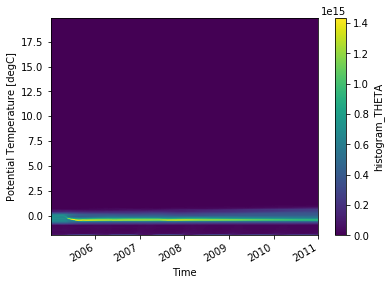

In [16]:
# most of the WG's waters is ~0˚C
# very little variability in temp distribution
theta_dist.plot(x='time')

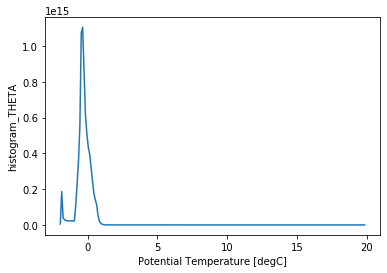

In [17]:
# most of the WG's water is at freezing pt (0˚C)
theta_dist.mean(dim='time').plot()

(-2, 5)

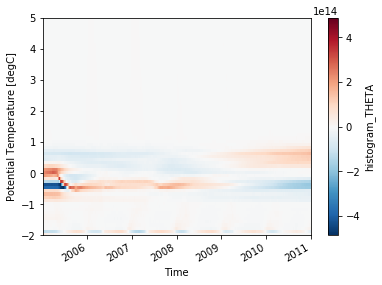

In [18]:
# theta distribution anomaly
(theta_dist - theta_dist.mean(dim='time')).plot(x='time')
plt.ylim([-2, 5])

# $\frac{\partial \mathcal{V}}{\partial t}$

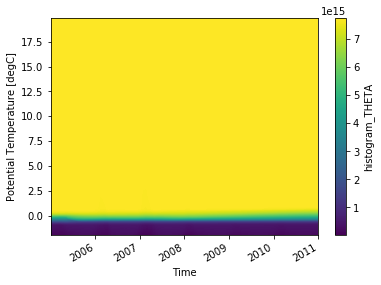

In [19]:
# cumulative volume
V = theta_dist.cumsum(dim='THETA_bin')
V.transpose().plot()

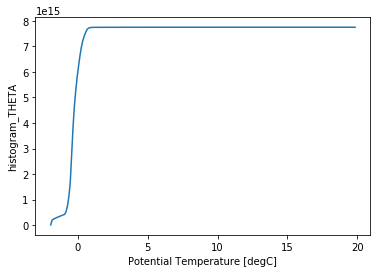

In [20]:
#time avg of cumulative volume
V_mean = V.mean(dim='time')
V_mean.plot()

(-2, 7)

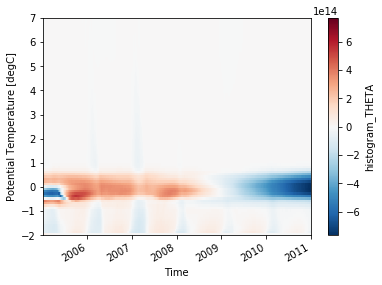

In [21]:
#cumulative volume anomaly
V_anom = V - V_mean
V_anom.plot(x='time')
plt.ylim(-2,7)

(-2, 7)

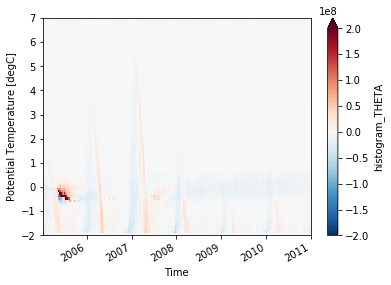

In [22]:
dt = 5*24*60*60
#using V_anom bc there is no change in V_mean
dVdt = V_anom.diff(dim='time') / dt
dVdt.plot(x='time', vmax=200e6)
plt.ylim(-2, 7)

# $\Psi$

$$
-\int_{\delta R}  (\mathbf{u} \cdot  \hat{\mathbf{n}} ) \mathcal{H}(\tilde \theta - \theta)\ dA
$$

$$
= -\int_{\tilde\theta_{min}}^{\tilde\theta_{max}} d\tilde\theta \int_{\delta R}  (\mathbf{u} \cdot  \hat{\mathbf{n}} ) \delta(\tilde\theta - \theta)\ dA
$$

In [23]:
vels

<xarray.Dataset>
Dimensions:  (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, time: 438)
Coordinates:
  * XG       (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
Data variables:
    UVEL     (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>

In [24]:
#the `isel` for boundaries is the product of vel components and normal vector part of the equation 
#multiplying by coords components is the "dA" part of the equation
u_transport_weddell = (vels.UVEL * coords.dyG * coords.drF * coords.hFacW).isel(**lat_range, XG=right_lon) #m^3/s
v_transport_weddell = (vels.VVEL * coords.dxG * coords.drF * coords.hFacS).isel(**lon_range, YG=upper_lat) #m^3/s
u_transport_weddell

<xarray.DataArray (time: 438, Z: 42, YC: 78)>
dask.array<getitem, shape=(438, 42, 78), dtype=float32, chunksize=(1, 42, 78), chunktype=numpy.ndarray>
Coordinates:
    XG       float32 359.83334
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -65.2083 -65.04163
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

**Why don't I sum over [XC, YC] for the surface integral part?**

In [25]:
u_transport_mean_value = u_transport_weddell.mean(dim='time').sum().values
u_transport_mean_value

array(-25396252., dtype=float32)

In [26]:
v_transport_mean_value = v_transport_weddell.mean(dim='time').sum().values
v_transport_mean_value

array(25411532., dtype=float32)

In [27]:
#residual potentially due to E-R-P
residual = u_transport_mean_value + v_transport_mean_value
residual #~0.0153Sv reasonable amount due to precip?

15280.0

#### Create xgcm grid

[Xgcm](http://xgcm.readthedocs.io) is a package which helps with the analysis of GCM data.

In [34]:
ds_tmp_wg

<xarray.Dataset>
Dimensions:                  (XC: 371, XG: 2160, YC: 78, YG: 320, Z: 42, Zl: 42, time: 438)
Coordinates:
  * XC                       (XC) float32 298.08334 298.25 ... 359.58334 359.75
  * YC                       (YC) float32 -77.87497 -77.7083 ... -65.04163
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * XG                       (XG) float32 5.551115e-17 0.16666667 ... 359.83334
  * YG                       (YG) float32 -77.9583 -77.79163 ... -24.791632
  * Zl                       (Zl) float32 0.0 -10.0 -21.0 ... -5200.0 -5450.0
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 78, 371), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 78, 371), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    lin_fs_correction_TH     (time, YC, XC) float32 dask.array<chunksize=(1, 78, 371), meta=np.ndarray>
    surface_flux_conv_TH     (time, YC, XC) float32 dask.array<chunksize=(1, 78, 371), meta=np.ndarray>
    sw_flux_conv_TH          (time, YC, XC, Z) float32 dask.array<chunksize=(1, 78, 371, 41), meta=np.ndarray>
    SALT                     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    THETA                    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>

In [38]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-sose'), consolidated=True)

import xgcm
grid = xgcm.Grid(ds, periodic=('X', 'Y'))
grid

<xgcm.Grid>
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
Y Axis (periodic):
  * center   YC --> left
  * left     YG --> center
T Axis (not periodic):
  * center   time

In [39]:
#interpolating theta to be on same grid pt as velocity components
theta_at_u = grid.interp(ds_tmp_wg.THETA, 'X')
theta_at_v = grid.interp(ds_tmp_wg.THETA, 'Y', boundary='extend')

ValueError: conflicting sizes for dimension 'XG': length 371 on the data but length 2160 on coordinate 'XG'

In [ ]:
theta_uvel = theta_at_u.isel(**lat_range, XG=right_lon)
theta_vvel = theta_at_v.isel(**lon_range, YG=upper_lat)

In [ ]:
#plt.figure(figsize=(12,8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8), sharey=True)

theta_vvel[0].plot(ax=ax1)
#temperature values at vvel values in WG region in timestep:0
ax1.title.set_text('temp at meridional velocity locations')

theta_uvel[0].plot(ax=ax2)
#temperature values at uvel values in WG region in timestep:0
ax2.title.set_text('temp at zonal velocity locations')

plt.tight_layout();

In [ ]:
uvel = dsr.UVEL.isel(**lat_range, XG=right_lon)
vvel = dsr.VVEL.isel(**lon_range, YG=upper_lat)

**Try to make movie of the figures (Julian's `xmovie` package)**

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8), sharey=True)

theta_vvel[0].plot(ax=ax1)
vvel[0].plot.contour(ax=ax1, colors='k', levels=np.arange(-0.1, 0.1, 0.02))
ax1.title.set_text('temp at meridional velocity locations\n with meridional vel contours')

theta_uvel[0].plot(ax=ax2)
uvel[0].plot.contour(ax=ax2, colors='k', levels=np.arange(-0.1, 0.1, 0.02))
ax2.title.set_text('temp at zonal velocity locations\n with zonal vel contours')

plt.tight_layout();

In [ ]:
#this is the delta function part of the equation above
u_binned = histogram(theta_uvel.rename('theta'), bins=[theta_bins],
                     weights=u_transport_weddell, dim=['Z', 'YC'])
v_binned = histogram(theta_vvel.rename('theta'), bins=[theta_bins],
                     weights=v_transport_weddell, dim=['Z', 'XC'])

In [ ]:
u_binned

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8), sharey=True)

v_binned.plot(ax=ax1)
ax1.title.set_text('meridional velocity in temperature space\n in WG region')

u_binned.plot(ax=ax2)
ax2.title.set_text('zonal velocity in temperature space\n in WG region')

plt.tight_layout();

In [ ]:
transport_binned = u_binned + v_binned
transport_binned.load()

In [ ]:
transport_binned.max()

In [ ]:
transport_binned.sum(dim='theta_bin').plot()
plt.ylim([-2e6, 2e6])

In [ ]:
(transport_binned/1e6).transpose().plot(figsize=(12,8))
plt.title('Horizontal Transport in Sv', fontsize=16)
plt.ylim([-2, 2]);

In [ ]:
#this is the theta integral part of the equation
transport_weddell = - transport_binned.cumsum(dim='theta_bin')
transport_weddell

In [ ]:
(transport_weddell/1e6).transpose().plot(figsize=(12,8))
plt.ylim(-2,2)
plt.title(r'Psi component of $\frac{\partial\mathcal{V}}{\partial t}$ in Sv', fontsize=16);

### **Testing**

# $\Omega$

$$
-\int_R \delta(\tilde \theta - \theta) \dot \theta dV
$$

### Adv & Diff terms

In [ ]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(ds_tmp_wg.THETA.rename('theta'), bins=[theta_bins],
              weights=variable, dim=['XC', 'YC', 'Z'])
    return hist

In [ ]:
#this is the delta function part of the equation
fluxes = [ds_tmp_wg.conv_horiz_diff_flux_TH,
          ds_tmp_wg.conv_vert_adv_flux_TH,
          ds_tmp_wg.conv_vert_diff_flux_TH]

fluxes_binned = histogram_func(ds_tmp_wg.conv_horiz_adv_flux_TH.chunk(
                            {'XC': -1, 'YC': -1, 'Z': -1, 'time': 1})).to_dataset(
                                                    name='conv_horiz_adv_flux_TH')
for var in fluxes:
    new_vars = histogram_func(var.chunk({'XC': -1, 'YC': -1, 'Z': -1, 'time': 1})).rename(var.name)
    fluxes_binned = xr.merge([fluxes_binned, new_vars], compat='override')

In [ ]:
fluxes_binned.load()

**How do you set ylim for all the subplots without having to rewrite `set_ylim` manually everytime?**

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18,12), sharex=True)

#plt.setp([axes[0,0], axes[0,1]], ylim=(-2,2))
#plt.setp(axes, ylim=(-2,2))

fluxes_binned.conv_horiz_adv_flux_TH.transpose().plot(ax=axes[0,0])
axes[0,0].set_title('Advective flux term - horizontal term', fontsize=18)
axes[0,0].set_ylim(-2,2)

fluxes_binned.conv_horiz_diff_flux_TH.transpose().plot(ax=axes[0,1])
axes[0,1].set_title('Diffusive flux term - horizontal term', fontsize=18)
axes[0,1].set_ylim(-2,2)

fluxes_binned.conv_vert_adv_flux_TH.transpose().plot(ax=axes[1,0])
axes[1,0].set_title('Advective flux term - vertical term', fontsize=18)
axes[1,0].set_ylim(-2,2)

fluxes_binned.conv_vert_diff_flux_TH.transpose().plot(ax=axes[1,1])
axes[1,1].set_title('Diffusive flux term - vertical term', fontsize=18)
axes[1,1].set_ylim(-2,2)

plt.suptitle('Advective & Diffusive Flux Terms', weight='bold', fontsize=24);

### Surface terms

In [ ]:
#delta part of the equation
sw_binned = histogram_func(ds_tmp_wg.sw_flux_conv_TH.chunk(
                 {'XC': -1, 'YC': -1, 'Z': -1, 'time': 1})).load()

In [ ]:
#delta part of the equation
surf_binned = histogram(ds_tmp_wg.THETA.isel(Z=0).rename('theta'), bins=[theta_bins],
                        weights=ds_tmp_wg.surface_flux_conv_TH, dim=['XC', 'YC']).load()

lin_fs_binned = histogram(ds_tmp_wg.THETA.isel(Z=0).rename('theta'), bins=[theta_bins],
                          weights=ds_tmp_wg.lin_fs_correction_TH, dim=['XC', 'YC']).load()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18,12))

(sw_binned/1e6).transpose().plot(ax=axes[0,0])
axes[0,0].set_title('Shortwave term in Sv', fontsize=18)
axes[0,0].set_ylim(-2,7)

(surf_binned/1e6).transpose().plot(ax=axes[0,1])
axes[0,1].set_title('Surface term in Sv', fontsize=18)
axes[0,1].set_ylim(-2,7)

(lin_fs_binned/1e6).transpose().plot(ax=axes[1,0])
axes[1,0].set_title('Linear free surface correction term in Sv', fontsize=18)
axes[1,0].set_ylim(-2,1)


plt.tight_layout();

In [ ]:
omega = - (fluxes_binned.conv_horiz_diff_flux_TH + 
           fluxes_binned.conv_vert_diff_flux_TH +
           sw_binned + 
           surf_binned + 
           lin_fs_binned)
omega

In [ ]:
(omega/1e6).transpose().plot(figsize=(12,8), vmax=10 )
plt.ylim(-2,20)
plt.title(r'Omega component of $\frac{\partial\mathcal{V}}{\partial t}$ in Sv', fontsize=16);

### $\Psi + \Omega$

In [ ]:
tendency_term = (transport_weddell + omega)
tendency_term

In [ ]:
#time_avg to get right of lhs
tendency_term_mean = tendency_term.mean(dim='time')
(tendency_term_mean/1e6).plot()

### $\frac{\int \frac{\partial \mathcal{V}}{\partial t}\ dt}{t - t_0}$

In [ ]:
dVdt_time_mean = dVdt.mean(dim='time')
dVdt_time_mean

In [ ]:
(dVdt_time_mean/1e6).plot()

### $\frac{\int \frac{\partial \mathcal{V}}{\partial t}\ dt}{t - t_0} = \bar{\Psi} + \bar{\Omega}$

In [ ]:
plt.figure(figsize=(12,6))
(dVdt_time_mean/1e6).plot(label='lhs')
(tendency_term_mean/1e6).plot(label='rhs')
plt.legend()
plt.title('WMT in Sv', fontsize=20);

Almost all of the water in the WG is leaving the basin - mostly water with temperatures between -2 and 2. The watermass of about 0˚C has largest amount of transformation.

**Next Steps:**
- bin surface term and sw term
- sum all the binned terms together
- plot the summed terms and compare to psi - taking time mean should make $\mathcal{V} = \bar{\Psi} + \bar{\Omega}$ 
- sum $\Psi$ and $\Omega$ and compare plot to $\frac{\partial\mathcal{V}}{\partial t}$ plot (should equal)
- create ECCO datasets and repeat process for ECCO model (i.e. 
    1. Validate t/s budgets to check datasets are consistent
    2. $\frac{\partial \mathcal{V}}{\partial t} = \Psi + \Omega$

**Check by hand if $\mathcal{V} = \bar{\Psi} + \bar{\Omega}$ is true**